<a href="https://colab.research.google.com/github/tymor22/tm-vec/blob/master/google_colabs/Use_TM_Vec_to_predict_TM_Scores_for_pairs_of_sequences.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Notes:
1. In order to use TM-Vec and DeepBlast, you need to install TM-Vec, DeepBlast, and the huggingface transformers library. 
2. You will also need to download the ProtT5-XL-UniRef50 encoder (large language model that TM-Vec and DeepBlast uses), the trained TM-Vec model, and the trained DeepBlast model. As the ProtT5-XL-UniRef50 encoder is very large (~11.3GB), unless you have the necessary RAM on your GPU (at least more than the model), you may have to use a CPU runtime on Google Colab.
3. This notebook demonstrates how TM-Vec can be used to predict TM-Scores for pairs of protein sequences.


<h3>Predicting TM-Scores using a trained TM-Vec model</h3>

**1. Install the relevant libraries including tm-vec, deepblast, and the huggingface transformers library**

In [ ]:
!pip install tm-vec

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 800 kB 13.2 MB/s 
     |████████████████████████████████| 3.1 MB 81.5 MB/s 
     |████████████████████████████████| 5.8 MB 49.3 MB/s 
     |████████████████████████████████| 512 kB 61.1 MB/s 
     |████████████████████████████████| 125 kB 60.6 MB/s 
     |████████████████████████████████| 182 kB 72.2 MB/s 
     |████████████████████████████████| 7.6 MB 81.5 MB/s 
  Created wheel for tm-vec: filename=tm_vec-0.1.0-py3-none-any.whl size=9674 sha256=d7424fb4ff4c6ad849d8ada715ffe48be159b7de0650099e4daef17e79c29cd6
  Stored in directory: /root/.cache/pip/wheels/90/cd/15/1f63ae4cfac3acbfecc598f120bcd4ad35d8caa47e6a473501
  Created wheel for deepblast: filename=deepblast-0.1.0-py3-none-any.whl size=38363 sha256=c5fba7606d82264ca55a2431de44762fd5bb4dde61344ec352e7ed7b45d41f11
  Stored in directory: /root/.cache/pip/wheels/56/cf/4e/e77a41552db1e28f8d613076dad

In [ ]:
!pip install deepblast

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -q SentencePiece transformers

     |████████████████████████████████| 1.3 MB 13.6 MB/s 


<b>2. Load the relevant libraries<b>

In [ ]:
import torch
from transformers import T5EncoderModel, T5Tokenizer
import re
import gc

import numpy as np
import pandas as pd

import torch
from torch.utils.data import Dataset

from tm_vec.embed_structure_model import trans_basic_block, trans_basic_block_Config
from tm_vec.tm_vec_utils import featurize_prottrans, embed_tm_vec, cosine_similarity_tm


import matplotlib.pyplot as plt
import seaborn as sns 


<b>3. Load the ProtT5-XL-UniRef50 tokenizer and model<b>

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_uniref50", do_lower_case=False )

Downloading:   0%|          | 0.00/238k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.79k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/546 [00:00<?, ?B/s]

In [ ]:
model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_uniref50")

Downloading:   0%|          | 0.00/11.3G [00:00<?, ?B/s]

Some weights of the model checkpoint at Rostlab/prot_t5_xl_uniref50 were not used when initializing T5EncoderModel: ['decoder.block.16.layer.0.SelfAttention.o.weight', 'decoder.block.3.layer.1.EncDecAttention.q.weight', 'decoder.block.16.layer.0.SelfAttention.v.weight', 'decoder.block.18.layer.1.EncDecAttention.v.weight', 'decoder.block.8.layer.0.SelfAttention.k.weight', 'decoder.block.17.layer.1.EncDecAttention.q.weight', 'decoder.block.11.layer.1.layer_norm.weight', 'decoder.block.11.layer.0.SelfAttention.o.weight', 'decoder.block.12.layer.2.DenseReluDense.wo.weight', 'decoder.block.10.layer.2.layer_norm.weight', 'decoder.block.0.layer.1.EncDecAttention.k.weight', 'decoder.block.6.layer.2.DenseReluDense.wo.weight', 'decoder.block.15.layer.0.SelfAttention.k.weight', 'decoder.block.8.layer.0.layer_norm.weight', 'decoder.block.20.layer.2.DenseReluDense.wo.weight', 'decoder.block.0.layer.0.SelfAttention.q.weight', 'decoder.block.19.layer.2.DenseReluDense.wi.weight', 'decoder.block.2.laye

In [ ]:
gc.collect()

16

<b>3. Put the model onto your GPU if it is avilabile, switching the model to inference mode<b>

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
print(device)

cpu


In [ ]:
model = model.to(device)
model = model.eval()

<b>4. Download a trained TM-Vec model, and its configuration file<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt

--2022-12-21 16:37:24--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model.ckpt
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt [following]
--2022-12-21 16:37:24--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model.ckpt
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 207922348 (198M) [application/octet-stream]
Saving to: ‘tm_vec_cath_model.ckpt’

tm_vec_cath_model.c 100%[===================>] 198.29M  25.0MB/s    in 7.7s    

2022-12-21 16:37:32 (25.8 MB/s) - ‘tm_vec_cath_model.ckpt’ saved [207922348/207922348]



In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json

--2022-12-21 16:37:32--  https://users.flatironinstitute.org/thamamsy/public_www/tm_vec_cath_model_params.json
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json [following]
--2022-12-21 16:37:33--  https://users.flatironinstitute.org/~thamamsy/tm_vec_cath_model_params.json
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 181 [application/json]
Saving to: ‘tm_vec_cath_model_params.json’

tm_vec_cath_model_p 100%[===================>]     181  --.-KB/s    in 0s      

2022-12-21 16:37:33 (57.5 MB/s) - ‘tm_vec_cath_model_params.json’ saved [181/181]



<b> 5. Load the trained TM-Vec model<b>

In [ ]:
#TM-Vec model paths
tm_vec_model_cpnt = "tm_vec_cath_model.ckpt"
tm_vec_model_config = "tm_vec_cath_model_params.json"

#Load the TM-Vec model
tm_vec_model_config = trans_basic_block_Config.from_json(tm_vec_model_config)
model_deep = trans_basic_block.load_from_checkpoint(tm_vec_model_cpnt, config=tm_vec_model_config)
model_deep = model_deep.to(device)
model_deep = model_deep.eval()

<b> 6. Load or paste some pairs of protein sequences that you would like to predict TM-Scores for<b>

In [ ]:
!wget https://users.flatironinstitute.org/thamamsy/public_www/malidup_sequences_and_tm_scores.csv

--2022-12-21 16:41:25--  https://users.flatironinstitute.org/thamamsy/public_www/malidup_sequences_and_tm_scores.csv
Resolving users.flatironinstitute.org (users.flatironinstitute.org)... 144.121.86.9
Connecting to users.flatironinstitute.org (users.flatironinstitute.org)|144.121.86.9|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://users.flatironinstitute.org/~thamamsy/malidup_sequences_and_tm_scores.csv [following]
--2022-12-21 16:41:25--  https://users.flatironinstitute.org/~thamamsy/malidup_sequences_and_tm_scores.csv
Reusing existing connection to users.flatironinstitute.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 65007 (63K) [application/octet-stream]
Saving to: ‘malidup_sequences_and_tm_scores.csv’

malidup_sequences_a 100%[===================>]  63.48K  --.-KB/s    in 0.08s   

2022-12-21 16:41:25 (806 KB/s) - ‘malidup_sequences_and_tm_scores.csv’ saved [65007/65007]



In [ ]:
sequences = pd.read_csv('malidup_sequences_and_tm_scores.csv')

In [ ]:
#Sample some sequences (for running on CPU which is much slower)
sequence_df = sequences.sample(25).reset_index(drop=True)

<b> 7. Predict TM-Scores using TM-Vec <b> 



In [ ]:
#This will be much faster (orders of magnitude) on a GPU than a CPU
tm_score_predictions = []
for i in range(sequence_df.shape[0]):
    sequence_1 = sequence_df.loc[i, 'Sequence 1']
    sequence_2 = sequence_df.loc[i, 'Sequence 2']
    
    sequence_1 = np.expand_dims(sequence_1, axis=0)
    sequence_2 = np.expand_dims(sequence_2, axis=0)
    
    #Featurize sequence 1 and 2 using ProtTrans
    protrans_sequence_1 = featurize_prottrans(sequence_1, model, tokenizer, device).detach()
    protrans_sequence_2 = featurize_prottrans(sequence_2, model, tokenizer, device).detach()

    #Embed sequence 1 and 2 using TM-Vec, applied to the ProtTrans features
    embedded_sequence_1 = embed_tm_vec(protrans_sequence_1, model_deep, device)
    embedded_sequence_2 = embed_tm_vec(protrans_sequence_2, model_deep, device)
    
    #Predict the TM-score for sequence 1 and 2, using the TM-Vec embeddings
    predicted_tm_score = cosine_similarity_tm(torch.tensor(embedded_sequence_1), torch.tensor(embedded_sequence_2))
    
    tm_score_predictions.append(predicted_tm_score.numpy()[0])

    if i % 10 == 0:
      print(i, " TM-Scores predicted")

0  TM-Scores predicted
10  TM-Scores predicted
20  TM-Scores predicted


<b>8. Visualize TM-score predictions versus the ground truth TM-scores<b>

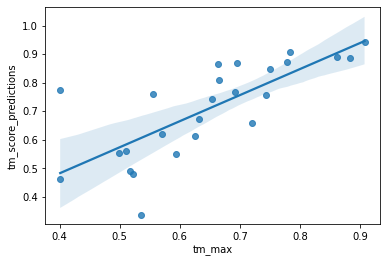

In [ ]:
sequence_df['tm_score_predictions'] = np.array(tm_score_predictions)
sns.regplot(data=sequence_df, x="tm_max", y="tm_score_predictions")